In [54]:
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import warnings


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [101]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

In [151]:
data_path = pathlib.Path("../data")

df_games = pd.concat((pd.read_csv(file) for file in data_path.glob("*.csv")))

df_games = df_games.drop_duplicates(subset="board_string").reset_index(drop=True)

In [161]:
piece_type = [
    "WHITE_PAWN",
    "WHITE_BISHOP",
    "WHITE_KNIGHT",
    "WHITE_ROOK",
    "WHITE_QUEEN",
    "WHITE_KING",
    "BLACK_PAWN",
    "BLACK_BISHOP",
    "BLACK_KNIGHT",
    "BLACK_ROOK",
    "BLACK_QUEEN",
    "BLACK_KING",
]


piece_count = {}

for index, row in df_games.iterrows():
    board_string = row['board_string']

    output = {}

    for i in range(12):
        piece = piece_type[i]
        output[piece] = board_string[64 * i : 64 * (i + 1)].count('1')    
        
    output = pd.Series(output)

    piece_count[index] = output
    
piece_count = pd.DataFrame(piece_count).T

df = pd.concat((df_games, piece_count), axis=1)

# Only keep not forcing positions
df = df.loc[df["target_eval"].abs() < 10]
df = df.drop(columns=['board_string', "WHITE_KING", "BLACK_KING"])

df

,dynamic_eval,king_safety_eval,material_eval,positional_eval,pressure_eval,capture_eval,target_eval,WHITE_PAWN,WHITE_BISHOP,WHITE_KNIGHT,WHITE_ROOK,WHITE_QUEEN,BLACK_PAWN,BLACK_BISHOP,BLACK_KNIGHT,BLACK_ROOK,BLACK_QUEEN
0,1.000000,0.300000,0.0,0.0,-4.440892e-16,0.0,-8.570922e-16,8,2,2,2,1,8,2,2,2,1
1,3.445101,0.325892,0.0,16.0,7.754015e+01,0.0,6.091017e-01,8,2,2,2,1,8,2,2,2,1
2,1.000000,0.300000,0.0,0.0,7.061018e-14,0.0,1.008083e-15,8,2,2,2,1,8,2,2,2,1
3,4.254021,0.697724,0.0,12.0,5.541551e+01,0.0,4.509095e-01,8,2,2,2,1,8,2,2,2,1
4,1.000000,0.300000,0.0,0.0,4.218847e-14,0.0,-7.327472e-16,8,2,2,2,1,8,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,8.202994,1.880474,4.0,34.0,9.715592e+01,0.0,5.616735e+00,1,0,1,0,0,0,0,0,0,0
849,10.630989,2.114917,4.0,34.0,9.766612e+01,0.0,5.888735e+00,1,0,1,0,0,0,0,0,0,0
850,10.630989,2.667065,4.0,34.0,1.889661e+02,0.0,6.036653e+00,1,0,1,0,0,0,0,0,0,0
851,8.409789,2.197713,4.0,37.0,1.515807e+02,0.0,6.036653e+00,1,0,1,0,0,0,0,0,0,0


<Axes: xlabel='target_eval', ylabel='Count'>

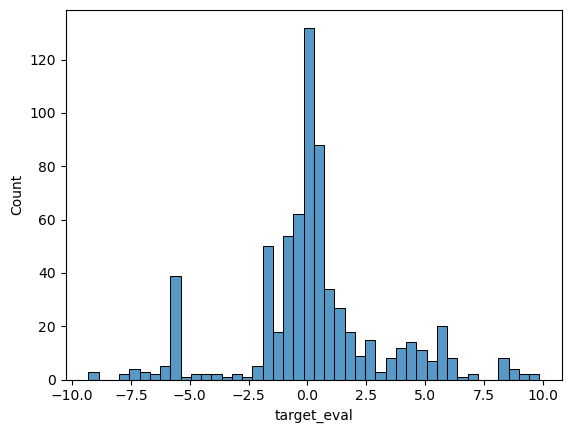

In [177]:
sns.histplot(df['target_eval'])

In [163]:
X = df.copy()

# Get result of alpha-beta search
y = X.pop("target_eval")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [164]:
def evaluate(y_true, y_hat):
    print("Base Eval R2:", r2_score(y_true, y_hat))
    print("Base Eval MAE:", mean_absolute_error(y_true, y_hat))
    print("Base Eval MAPE:", mean_absolute_percentage_error(y_true, y_hat))
    print("Base Eval Correlation:", np.corrcoef(y_true, y_hat)[0, 1])

In [165]:
def get_baseline(X, y):
    return X["capture_eval"] + X["material_eval"] + 0.01 * X["pressure_eval"]

def eval_baseline(X, y):
    base_eval = get_baseline(X, y)
    evaluate(y, base_eval)
    
    return base_eval

In [166]:
print("Train:")
eval_baseline(X_train, y_train)

print()
print("Test:")
eval_baseline(X_test, y_test)

print()

Train:
Base Eval R2: 0.8659583060254308
Base Eval MAE: 0.6233328895594202
Base Eval MAPE: 1.9342076698430035
Base Eval Correlation: 0.9308743252734384

Test:
Base Eval R2: 0.8049393411857333
Base Eval MAE: 0.776638124128218
Base Eval MAPE: 1.331092799687035
Base Eval Correlation: 0.8978620608071536



In [175]:
# linear_model = LinearRegression(fit_intercept=False)

base_eval = get_baseline(X_train, y_train)

linear_model = LinearRegression(fit_intercept=False) # Ridge(alpha=1, fit_intercept=False)

model = make_pipeline(
    StandardScaler(with_mean=False),
    linear_model
)

model.fit(X_train, y_train)

print("Train:")
evaluate(y_train, model.predict(X_train))

print()
print("Test:")
evaluate(y_test, model.predict(X_test))

print()


Train:
Base Eval R2: 0.8801887601781415
Base Eval MAE: 0.6345710347176038
Base Eval MAPE: 2029466918451.9941
Base Eval Correlation: 0.9381889501334082

Test:
Base Eval R2: 0.8119313908805806
Base Eval MAE: 0.7964411396448846
Base Eval MAPE: 4296894791735.649
Base Eval Correlation: 0.9011023409989252



In [176]:
pd.Series(model[-1].coef_ / model[0].scale_, model[0].get_feature_names_out())

dynamic_eval       -0.020743
king_safety_eval    0.279307
material_eval       0.887878
positional_eval     0.003255
pressure_eval       0.008704
capture_eval        0.965248
WHITE_PAWN          0.072693
WHITE_BISHOP        0.040098
WHITE_KNIGHT        0.253661
WHITE_ROOK         -0.048741
WHITE_QUEEN         1.053231
BLACK_PAWN         -0.025138
BLACK_BISHOP       -0.132439
BLACK_KNIGHT       -0.231060
BLACK_ROOK         -0.262435
BLACK_QUEEN        -0.865598
dtype: float64